In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.append('..')
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from data_tools import scaled_in, inv_scaled_ou
from data_tools import audio_files_to_numpy, numpy_audio_to_matrix_spectrogram, matrix_spectrogram_to_numpy_audio

In [2]:
# Setting Paths and Loading pre-trained neural network model from a JSON file and its corresponding weights
path_weights = '../weights/'

# load json and create model
json_file = open(path_weights+'model_unet_new.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(path_weights+'model_unet.h5')
print("Loaded model from disk")

Loaded model from disk


In [3]:
# Audio File Configuration and Setting audio-related parameters
audio_dir_prediction = '../demo_data/test'
audio_input_prediction = ['test3.wav']

sample_rate = 8000
min_duration = 6.0
frame_length = 8064
hop_length_frame = 8064
hop_length_frame_noise = 5000

In [4]:
# Loading and Processing Audio Data using a custom function 
audio = audio_files_to_numpy(audio_dir_prediction, audio_input_prediction, sample_rate,
                             frame_length, hop_length_frame, min_duration)

In [5]:
# Spectrogram Configuration
n_fft = 255
hop_length_fft = 63
dim_square_spec = int(n_fft / 2) + 1

In [6]:
# Creating Spectrograms
m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
    audio, dim_square_spec, n_fft, hop_length_fft)

In [7]:
# Scaling and Prediction
X_in = scaled_in(m_amp_db_audio)
X_in = X_in.reshape(X_in.shape[0], X_in.shape[1], X_in.shape[2], 1)
X_pred = loaded_model.predict(X_in)
inv_sca_X_pred = inv_scaled_ou(X_pred)

1/1 [==============================] - 0s 202ms/step


In [8]:
# Denoising and Reconstruction
X_denoise = m_amp_db_audio - inv_sca_X_pred[:, :, :, 0]
audio_denoise_recons = matrix_spectrogram_to_numpy_audio(
    X_denoise, m_pha_audio, frame_length, hop_length_fft)
nb_samples = audio_denoise_recons.shape[0]

In [9]:
# Play original noisy audio
noisy_audio_path = os.path.join(audio_dir_prediction, audio_input_prediction[0])
noisy_audio, _ = librosa.load(noisy_audio_path, sr=sample_rate, duration=min_duration)
ipd.display(ipd.Audio(noisy_audio, rate=sample_rate))

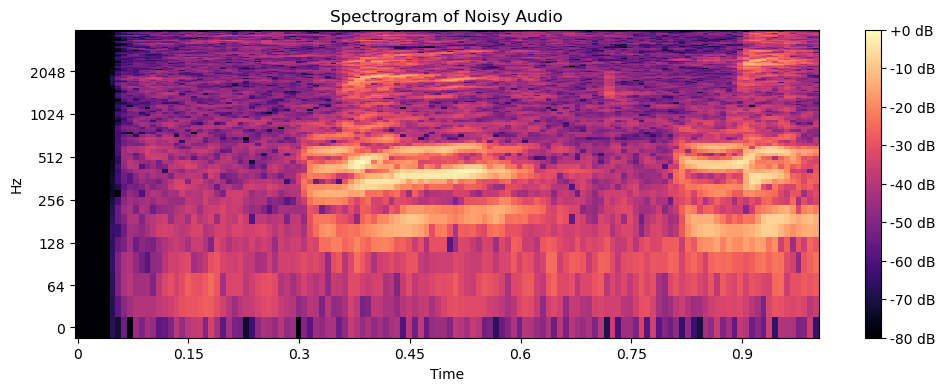

In [10]:
# Plot spectrogram of original noisy audio
plt.figure(figsize=(12, 4))
librosa.display.specshow(m_amp_db_audio[0, :, :], sr=sample_rate, hop_length=hop_length_fft, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Noisy Audio')
plt.show()

In [11]:
# Play denoised audio
ipd.display(ipd.Audio(audio_denoise_recons.flatten(), rate=sample_rate))

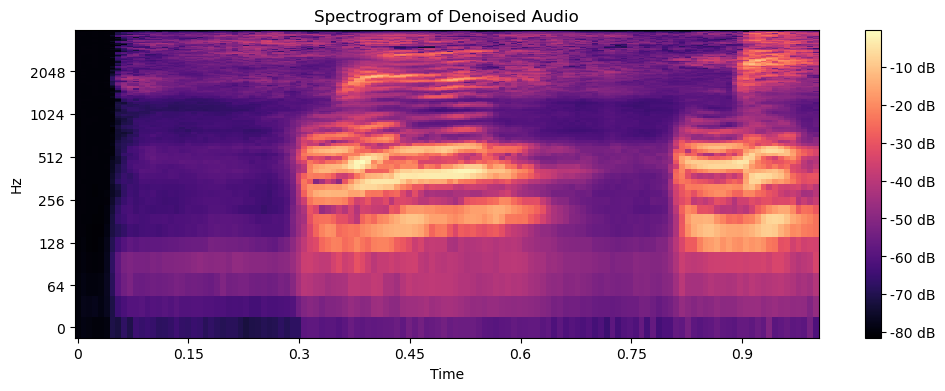

In [12]:
# Plot spectrogram of denoised audio
plt.figure(figsize=(12, 4))
librosa.display.specshow(X_denoise[0, :, :], sr=sample_rate, hop_length=hop_length_fft, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Denoised Audio')
plt.show()

In [13]:
# Asserting the Dimension of Spectrogram, Denoised Spectrogram, Number of Samples
def test_dimensions_spectrogram():
    """ test that dimensions are correct"""
    assert dim_square_spec == 128
    assert dim_square_spec == m_amp_db_audio.shape[1]
    assert dim_square_spec == m_amp_db_audio.shape[2]
    assert dim_square_spec == X_denoise.shape[1]
    assert dim_square_spec == X_denoise.shape[2]
    assert nb_samples == 5